In [1]:
!pip install praw
!pip install ffn
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas_datareader
pandas_datareader.__version__ 

'0.10.0'

In [8]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 300)
import praw #reddit data api
from praw.models import MoreComments # module to get replies to comments
import ffn  #for loading financial data
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

# from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
#VADER sentiment model
import requests
import json
import csv
import time
import datetime
import warnings 
warnings.filterwarnings("ignore")
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

In [4]:
base_path = "/content/drive/Othercomputers/My MacBook Pro/data-science/Georgia Tech/MGT6203- Data Analytics Business/MGT6203 Project/"
path= base_path + "draft/best_model_state.bin"
snp_tweet= 'data/tweets_labelled_09042020_16072020.csv'

## pure stock sentiment


In [60]:
live_tweets = pd.read_csv(base_path + snp_tweet, sep=';' )
live_tweets.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


In [61]:
df = live_tweets[['id', 'created_at', 'sentiment']]
df = df[df['sentiment'].notnull()]


In [62]:

# Encode the label
le = LabelEncoder()
le.fit(df['sentiment'])
print(list(le.classes_))
df['sentiment1'] = le.transform(df['sentiment'])
# list(le.inverse_transform(df['label']))
df.head()

['negative', 'neutral', 'positive']


,id,created_at,sentiment,sentiment1
0,77522,2020-04-15 01:03:46+00:00,positive,2
1,661634,2020-06-25 06:20:06+00:00,negative,0
2,413231,2020-06-04 15:41:45+00:00,positive,2
3,760262,2020-07-03 19:39:35+00:00,positive,2
4,830153,2020-07-09 14:39:14+00:00,positive,2


In [63]:
# sort values
df['created_at'] = pd.to_datetime(df['created_at'])
df= df.sort_values(by="created_at")

In [68]:
# group by day
df['created_date']= df['created_at'].dt.strftime('%Y-%m-%d')
df1 = df[['created_date', 'sentiment1']].groupby('created_date').mean()
df1.head()

,sentiment1
created_date,
2020-04-09,1.058824
2020-04-10,1.000000
2020-04-11,1.250000
2020-04-12,1.111111
2020-04-13,1.076923


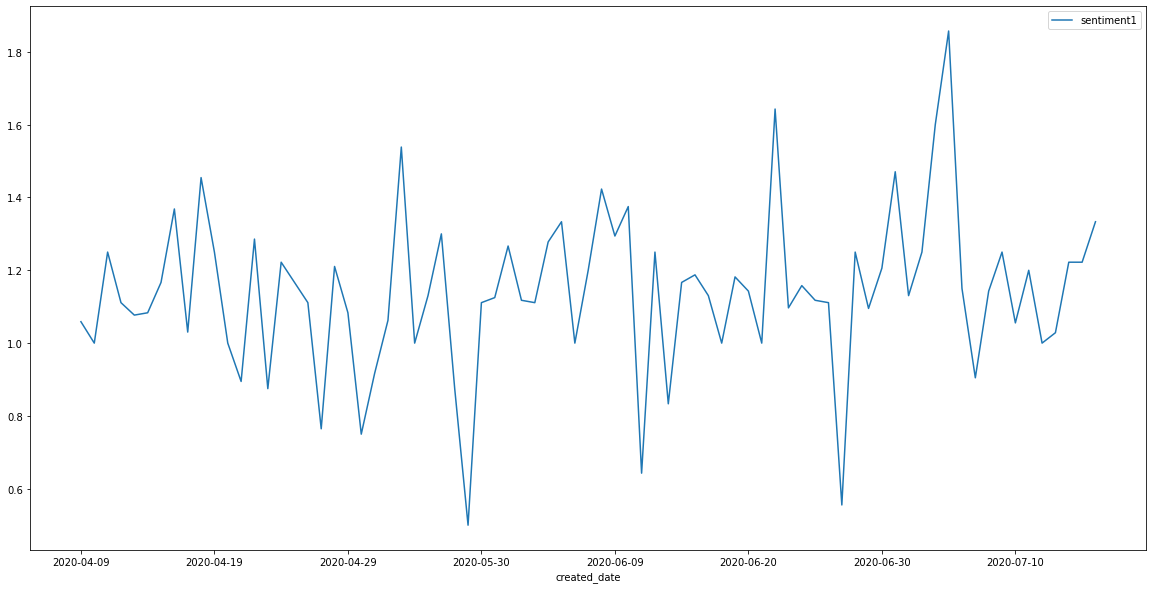

In [69]:

df1.plot( figsize=(20, 10));

In [36]:
min_date = df['created_at'].min().date().strftime('%Y-%m-%d')
max_date = df['created_at'].max().date().strftime('%Y-%m-%d')

In [70]:
spy=ffn.get('spy', start=min_date,  end=max_date)
spy['date'] = spy.index.astype(str) # convert date to string 
sent_vals = []


In [95]:
spy_senti = spy.merge(df1, how="inner", left_on="date", right_on="created_date")

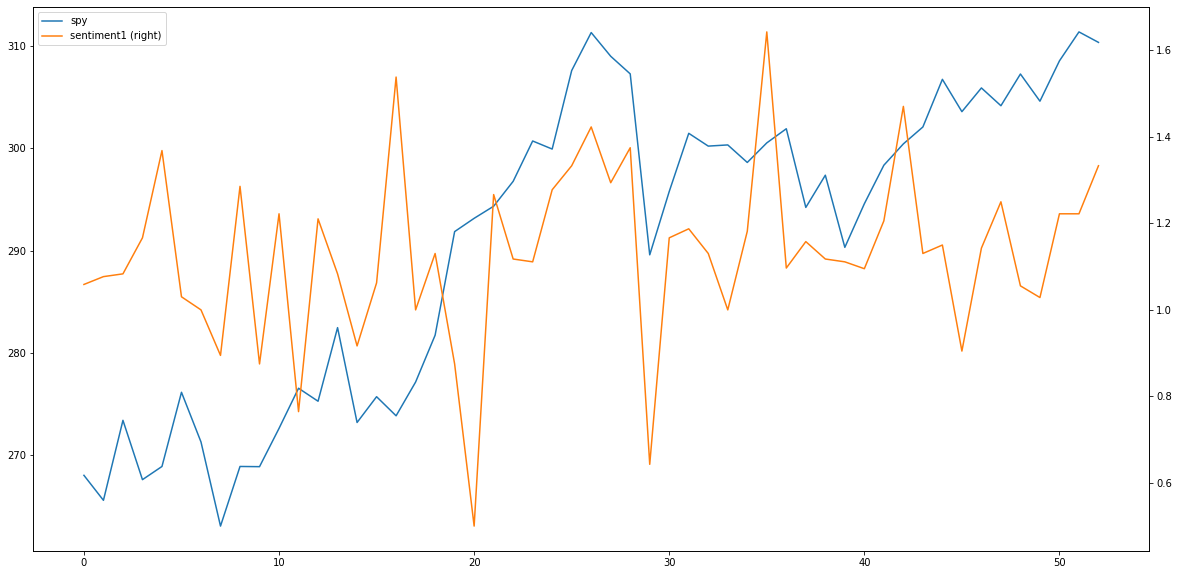

In [96]:
spy_senti.plot(secondary_y='sentiment1', figsize=(20, 10));

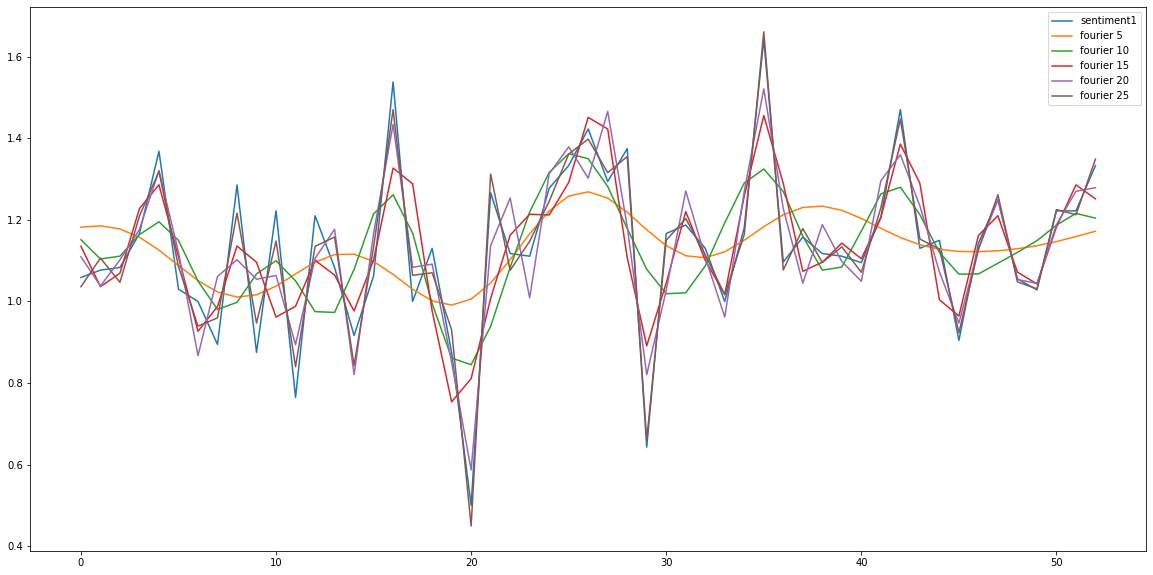

In [97]:

# extract sentiment score as a discrete fourier transform
price_fourier = np.fft.fft(np.asarray(spy_senti['sentiment1'].tolist())) # convert sentiment to FFT with numpy
fourier_df = pd.DataFrame({'fourier':price_fourier}) # add to a dataframe
fourier_list = np.asarray(fourier_df['fourier'].tolist())  # extract fourier score as array

for num_ in range(5,30,5): # create fourier columns with scores 20 and 25
  # compound fourier to smoothen signal
  fourier_list_m10= np.copy(fourier_list)
  fourier_list_m10[num_:-num_]=0 
  # transform back into time spectrum append each fourier to dataframe with name of fourier
  spy_senti['fourier '+str(num_)]=np.fft.ifft(fourier_list_m10)
    
# # plotting sentiment score and fourier transformed scores with different compounds
spy_senti[['sentiment1', 'fourier 5', 'fourier 10', 'fourier 15', 'fourier 20', 'fourier 25']].plot(figsize=(20, 10))


In [98]:
spy_senti = spy_senti.drop(['fourier 5', 'fourier 10', 'fourier 15', 'fourier 20'], axis = 1)

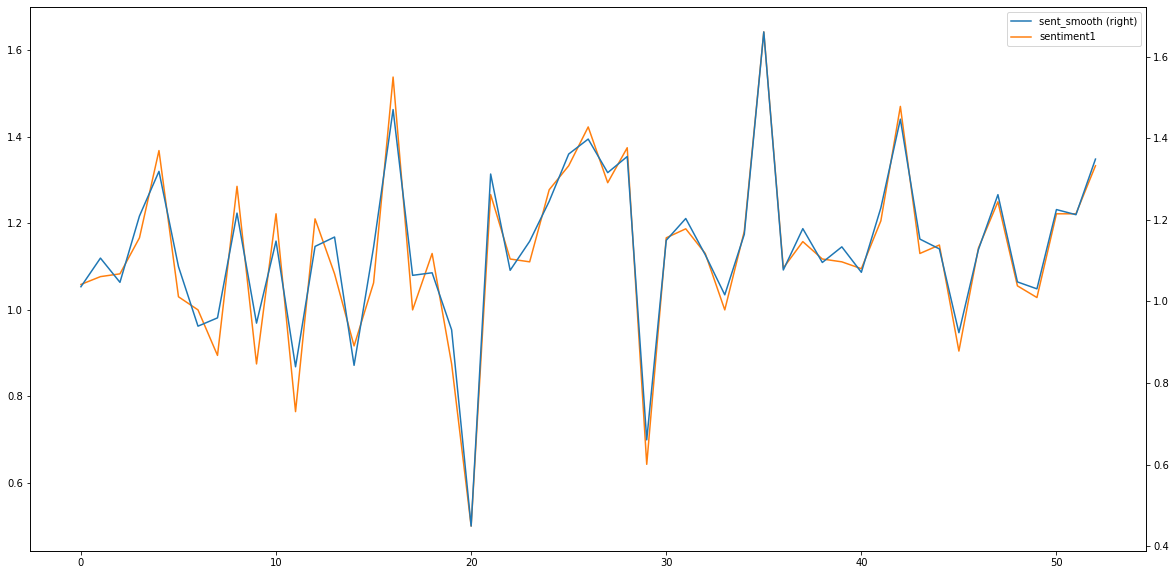

In [101]:
# convert fourier to real
spy_senti['sent_smooth'] = spy_senti['fourier 25'].apply(lambda x: np.real(x))
spy_senti[['sent_smooth', 'sentiment1']].plot(secondary_y='sent_smooth',figsize=(20, 10))

In [84]:
fourier_df.head()

,fourier
0,59.989731+0.000000j
1,-0.412489+1.605836j
2,0.798881-0.211164j
3,-0.084982-0.282074j
4,1.624624+0.341600j
